# Renyi Divergence Part 3

## Introduction

This is the final post in the series on Renyi alpha divergence Variational Inference. In previous posts, we derived the Renyi bound, proved a variety of properties, and showed how the bound varies with different alpha values for a closed gaussian system. 

In this post, we implement a stochastic version of the Renyi bound, and try it on a simple example.



## Stochastic Estimator

Recall the Renyi Bound $\mathcal{L_\alpha} =  \frac{1}{1 - \alpha} log \ E_{q}[(\frac{p(z, x)}{q(z)})^{1-\alpha}] $

We turn this into an (biased) stochastic estimate by approximating the integral in the expecation with an average over samples.

where $\hat{\mathcal{L_\alpha}} =  \frac{1}{1 - \alpha} log \ \frac{1}{K} \sum_{i=1}^{K}[(\frac{p(z_{i}, x)}{q(z_{i})})^{1-\alpha}] $

## Numerical Trick

When we have to compute the pdf of an exponential family, it is numerically more stable to compute it in logspace. With the KLD, the presence of the log means we never need to exponentiate the log pdf, leading to well behaved and stable computation.

With Renyi Divergence VI, the log is outside the expectation, so we have to exponentiate the log pdf before we average. This is fine in theory, but problematic when we do things in practice. 

In order to stablise the expecation computation, we subtract the max entry from all the values we which compute the mean over, compute the mean, then take the log and add back the max.

$ratio = (1-\alpha)[log \ P(x,z) - log \ q(z)]$

$adj = max(ratio)$

$[log \frac{1}{K} \sum exp(ratio-adj)] +  adj$

This helps when the entries of the vector of log probability ratios are large negative numbers. If they are very small, they become numerically zero in practice, and if this happens everywhere, the mean is then numerically zero and the log becomes - infinity. As an example, consider the equation below:

In [1]:
import numpy as np

log_p = np.random.random((10,1))*-10000
log_q = np.random.random((10,1))*10000
a = 0.5
ratio = (1-a)*(log_p - log_q)
print(np.log(np.mean(np.exp(ratio))))

-inf


/home/chris/anaconda2/envs/p3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


If we introduce the trick above, we see that it allows us to compute the value. You can change the multipliers to generate a more normal problem to see they are the same.

In [2]:
c = np.max(ratio)
print(np.log(np.mean(np.exp(ratio-c)))+c)

-2377.17256359


## An example in Pytorch

As with previous examples, we will generate a simple linear regression example, and show how the stochastic varient performs.

In [3]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Start by generating the same problem as before. A simple noisy linear relationship.

In [4]:
N = 200

X = np.random.uniform(low=-50, high=50, size=(N, 1)).astype(np.float64)
T = 3.2*X + np.random.normal(size=(N, 1), scale=5.5).astype(np.float64)

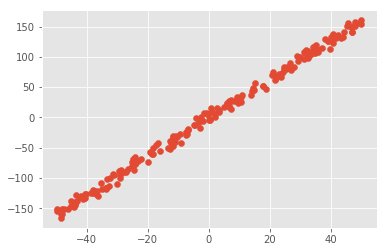

In [5]:
plt.scatter(X,T)

In [6]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [7]:
class MCRenyi(torch.nn.Module):
    def __init__(self, alpha=0.9):
        super(MCRenyi, self).__init__()
        self.n_latent = 10 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        self.alpha = alpha
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        self.qs= torch.nn.Parameter(torch.randn(1,1).double(), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = Variable(torch.randn(1,1).double(), requires_grad=False)
        self.prior_s = Variable(torch.randn(1,1).double(), requires_grad=False)
        self.likelihood_s = Variable(torch.DoubleTensor((1)), requires_grad=False)
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)

        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,1))
    
    def reparam(self, eps):
        eps = Variable(torch.DoubleTensor(eps))
        return  eps.mul(self.softplus(self.qs)).add(self.qm)
    
    def compute_renyi_bound(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)
        q_likelihood = log_norm(z, self.qm, self.softplus(self.qs))
        prior = log_norm(z, self.prior_m, self.prior_s)
        likelihood = torch.sum(log_norm(t, x*z.transpose(0,1), 
                                                   self.likelihood_s), 0, keepdim=True).transpose(0,1)
        
        ratio = (1-self.alpha)*(prior + likelihood -q_likelihood)
        const = torch.max(ratio)
        expectant = torch.exp((ratio-const))
        
        renyi_div = (torch.log(torch.mean(expectant))+const)/(1-self.alpha)
        return renyi_div

In [8]:
c = MCRenyi(alpha=0.2)
optimizer = torch.optim.Adam(c.parameters(),lr=0.01)
x = Variable(torch.DoubleTensor(X), requires_grad=False) 
t = Variable(torch.DoubleTensor(T), requires_grad=False)

for i in range(20001):
    loss = -c.compute_renyi_bound(x, t)
    #break
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    if i % 2500 ==0:
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[-0.48084967]] [[ 0.15816684]]
[[ 2.69328623]] [[ 0.82244459]]
[[ 3.28302152]] [[ 0.14089157]]
[[ 3.19240907]] [[ 0.02954172]]
[[ 3.20146107]] [[ 0.00767922]]
[[ 3.18926624]] [[ 0.00185215]]
[[ 3.22074138]] [[ 0.0003202]]
[[ 3.18371472]] [[ 0.00031177]]
[[ 3.19168896]] [[ 0.00028408]]


In [9]:
analytical_posterior_var = ((1/5.5**2)*X.T@ X +1)**-1
analytical_posterior_var

array([[ 0.00016908]])

In [10]:
analytical_posterior_mean = analytical_posterior_var*(0.9+((1/5.5**2)*X.T @ T))
analytical_posterior_mean

array([[ 3.20434673]])

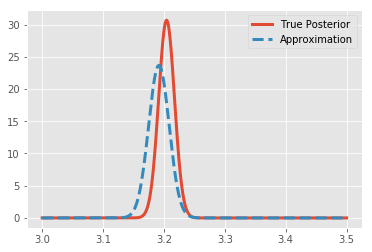

In [11]:
from scipy.stats import norm
xn = np.arange(3.0, 3.5, 0.0001)
true_dist = norm(loc = analytical_posterior_mean, 
                 scale =(analytical_posterior_var)**0.5)
q_dist = norm(loc = c.qm.data.numpy(), scale = c.softplus(c.qs).data.numpy())
yn = true_dist.pdf(xn).ravel()
plt.plot(xn, yn, linewidth=3, label="True Posterior")
plt.plot(xn, q_dist.pdf(xn).ravel(), '--', linewidth=3,
         label="Approximation")
plt.legend()


As this is a stochastic estimator, it bounces around, but with more latent samples and a more refined training procedure we could get it to converge exactly. With 10 latent samples, the biased-ness of the estimator has an impact, so it will not converge exactly. However, we see it still yields a good enough approximation for most purposes.

If the problem did not have an exact solution, the choice of alpha would also play a role.

# Summary

In this post, we have gone through a few important points about practically using Renyi Alpha Divergence for doing Variational Inference, and created a simple pytorch implementation of an example.